In [429]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import timm
import torch
from albumentations import (
    Compose,
    Normalize,
    ShiftScaleRotate,
    RandomBrightnessContrast,
    MotionBlur,
    CLAHE,
    HorizontalFlip
)
from copy import deepcopy
from torch.utils.data import Dataset
from tqdm.auto import tqdm
from PIL import Image

In [430]:
MODEL_PATH = "vinbigdata-chest-xray-resized-png-256x256/save_models"
MODEL_NAME = 'multilabel_efnb4_v1_cls'

In [431]:
model = timm.create_model('tf_efficientnet_b4_ns',pretrained=True,num_classes=15).cuda()
class_id = 0
model.load_state_dict(torch.load(os.path.join(MODEL_PATH, f'{MODEL_NAME}{class_id}.pth'))['weight'])

<All keys matched successfully>

In [432]:
DATASET_PATH = "vinbigdata-chest-xray-resized-png-256x256"

train_csv_path = os.path.join(DATASET_PATH, 'vindrcxr_train.csv')
test_csv_path = os.path.join(DATASET_PATH, 'vindrcxr_test.csv')
train_image_path = os.path.join(DATASET_PATH, 'train')
test_image_path = os.path.join(DATASET_PATH, 'test')
save_path = os.path.join(MODEL_PATH, '')

In [433]:
train = pd.read_csv(train_csv_path)
test = pd.read_csv(test_csv_path)

In [434]:
### Code from https://github.com/Scu-sen/VinBigData-Chest-X-ray-Abnormalities-Detection

class Dataset(Dataset):
    
    def __init__(self, df, image_path, transform=None):
        self.df = df
        self.image_path = image_path
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        labels = torch.from_numpy(
            self.df.loc[idx,np.arange(0,15).astype(str).tolist()].values.astype(float)
        ).float()
        
        image_id = str(self.df.image_id[idx])
        img = cv2.imread(
            self.image_path + '/' + str(self.df.image_id[idx]) + '.png'
        )
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(image=img)['image']
        img = torch.from_numpy(img.transpose((2, 0, 1))).float()
            
        return img, labels, image_id

In [435]:
bs = 1

train_transform = Compose([
    HorizontalFlip(p=0.5),
    ShiftScaleRotate(scale_limit = 0.15, rotate_limit = 10, p = 0.5),
    RandomBrightnessContrast(p=0.5),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
])

trainset = Dataset(
    test,
    image_path=test_image_path,
    transform=train_transform
)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=bs, num_workers=1,
    shuffle=True 
)

In [436]:
for data in train_loader:
    img, label, image_id = data
    img = img.to(torch.float)
    img = img.cuda()
    label = label.cuda()
    output = model(img)
    print(output)
    print(image_id, label)
    break

tensor([[ 1.3917, -4.9024, -3.2685,  0.7484, -4.6768, -3.6232, -3.8888, -2.5156,
         -2.7002, -2.0622, -3.4418, -1.8749, -5.3294, -2.1352, -4.2900]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
('6efc2a619fbf842eeadbb1abc9b523f5',) tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],
       device='cuda:0')


In [437]:
def compute_saliency_maps(images, labels, model):
    model.eval()
    saliency_list = []
    num_images = len(images)
    for i in range(num_images):
        X = images[i]
        y = labels[i]
        X.requires_grad_()
        scores = model(X)
        score_max_index = scores.argmax()
        score_max = scores[0, score_max_index]
        score_max.backward()
        saliency, _ = torch.max(torch.abs(X.grad.data), dim=1)
        saliency_list.append(saliency.cpu())
    return saliency_list

In [438]:
saliency_list = compute_saliency_maps([img], [label], model)

In [439]:
saliency_list[0].numpy().transpose(1,2,0).shape

(256, 256, 1)

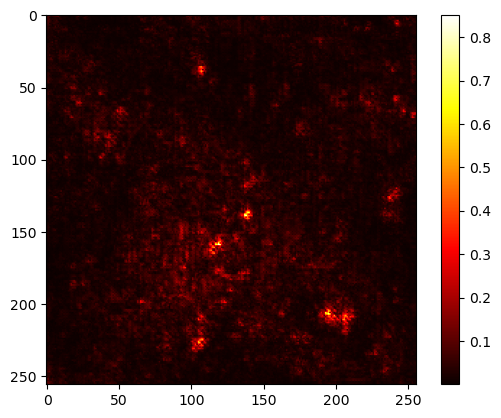

In [440]:
plt.imshow(saliency_list[0].numpy().transpose(1,2,0), cmap=plt.cm.hot)
plt.colorbar()
# plt.savefig("saliency_map.png")

In [441]:
image_id
img = cv2.imread(test_image_path + '/' + image_id[0] + '.png')

In [442]:
original_img = Image.fromarray(img)

In [443]:
print(label)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],
       device='cuda:0')


In [444]:
original_img.save(f"{image_id[0]}.png")

## Testing Code

In [378]:
# Image.fromarray(img)

In [376]:
# idx = 7
# image_id = train_df.loc[idx,"image_id"]
# img = cv2.imread(train_image_path + '/' + image_id + '.png')
# labels = train_df.loc[idx,np.arange(0,15).astype(str).tolist()].values.astype(float)
# print(f"Image ID: {image_id}")
# print(f"Labels: {labels}")

In [377]:
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img_tensor = torch.tensor(img).to(torch.float64)